In [1]:
# import required libraries

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import datetime
from datetime import timedelta

from pypmca import Model

In [2]:
abbrev = 'FR'
model_version = '4_4'
model_date = '_1002'

# file nameing convention
filename = abbrev.lower()+'_'+model_version+model_date+'.pypm'

# open the model saved in the file
model = Model.open_file(filename)
today = (datetime.date.today()-datetime.date(2020,3,1)).days

# run the model to calculate expectation values for all populations up until today
model.evolve_expectations(today)
# show the last 5 days of the population "hospitalized" (cumulative number admitted to hospital since start of epidemic)
model.populations['hospitalized'].history[-5:]

[552274.3653900111,
 552827.514318751,
 553399.8254166153,
 553992.4806059323,
 554606.6853459857]

In [3]:
# Some parameters of interest

show_all_parameters = False

# variants
variants = ['o','v','x']
names = {'o':'BA.1','v':'BA.2','x':'BA.4/5'}

par_names = []
if show_all_parameters:
    for par_name in list(model.parameters.keys()):
        parameter = model.parameters[par_name]
        if not parameter.hidden:
            par_names.append(par_name)
else:

    # latency parameters
    par_names.append('cont_delay_mean')
    par_names.append('cont_delay_sigma')
    # fraction who are symptomatic, and the fraction of symptomatic who are admitted to hospital
    par_names.append('symptomatic_frac')
    par_names.append('non_icu_hosp_frac')

    for var in ['v','x']:
        # transmission rate (alpha)
        par_names.append('alpha_1_'+var)
        # outbreak number (related to the introduction time)
        par_names.append('outbreak_'+var+'_number')    

        
for par_name in par_names:
    parameter = model.parameters[par_name]
    value = parameter.get_value()
    print(par_name,'('+parameter.description+')',round(value,4))


cont_delay_mean (mean time from being infected to becoming contagious) 5.0
cont_delay_sigma (standard deviation of times from being infected to becoming contagious) 3.0
symptomatic_frac (nominal fraction of contagious people who become symptomatic) 0.9
non_icu_hosp_frac (nominal fraction of those with symptoms who will be admitted to non_icu hospital) 0.0092
alpha_1_v (alpha_v after transition 1) 1.0937
outbreak_v_number (number of infections in outbreak_v) 0.0029
alpha_1_x (alpha_x after transition 1) 2.776
outbreak_x_number (number of infections in outbreak_x) 0.0277


In [4]:
# Some populations of interest

show_all_populations = False

pop_names = []
if show_all_populations:
    pop_names = list(model.populations.keys())
else:
    # variant specific populations:
    pop_names_var = ['contagious','infected']
    for pop_name_var in pop_names_var:
        for var in variants:
            pop_names.append(pop_name_var+'_'+var)

    # infection cycle populations:
    infection_cycles = ['os','ne']
    pop_names_inf = ['susceptible']
    for pop_name_inf in pop_names_inf:
        for inf in infection_cycles:
            pop_names.append(inf+'_'+pop_name_inf)

for pop_name in pop_names:
    print(pop_name,' - ',model.populations[pop_name].description)

contagious_o  -  contagious with type: original
contagious_v  -  contagious with type: variant
contagious_x  -  contagious with type: xariant
infected_o  -  infected by type: original
infected_v  -  infected by type: variant
infected_x  -  infected by type: xariant
os_susceptible  -  Susceptible:original susceptible
ne_susceptible  -  Susceptible:natural escape


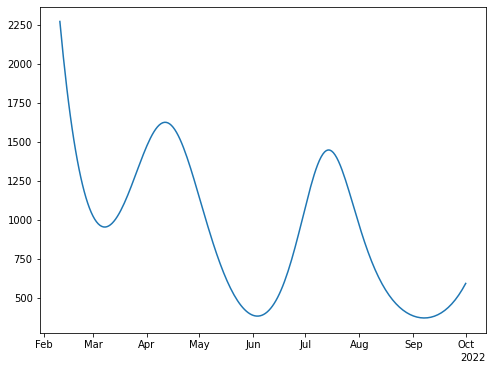

In [5]:
# plot the number of hospital admissions per day in 2022

days = []
dates = []
hosp_admins = []
date = datetime.date(2022,2,10)
while date < datetime.date.today():
    day = (date-datetime.date(2020,3,1)).days
    hosp_admin = model.populations['hospitalized'].history[day]-model.populations['hospitalized'].history[day-1]
    days.append(day)
    dates.append(date)
    hosp_admins.append(hosp_admin)
    date += timedelta(days=1)

fig, ax = plt.subplots(1,1,figsize=(8,6))
locator = mdates.AutoDateLocator()
formatter = mdates.ConciseDateFormatter(locator)
ax.xaxis.set_major_locator(locator)
ax.xaxis.set_major_formatter(formatter)
    
ax.plot(dates,hosp_admins)
plt.show()

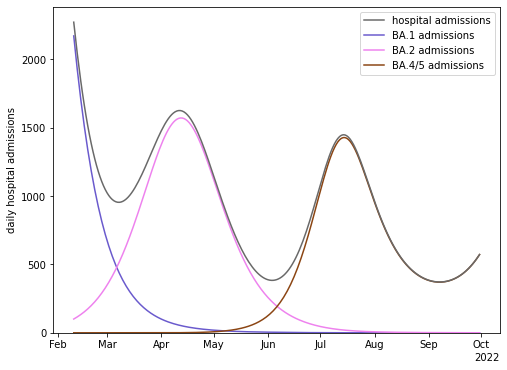

In [6]:
# show the hospital admissions broken down by variant type

def delta_period(cumul, ndp):
    diff = []
    for i in range(2*ndp-1,len(cumul),ndp):
        diff.append(cumul[i] - cumul[i-ndp])
    # first daily value is repeated since val(t0-1) is unknown
    diff.insert(0, diff[0])
    return diff

hosp_data = {}
hospitalized = {}

for var in variants:
    hospitalized[var] = {}
    hospitalized_var = np.array([0.]*len(model.populations['hospitalized'].history))
    pops = ['os_non_icu_hospitalized_'+var]
    if var == 'x':
        pops += ['ne_non_icu_hospitalized_'+var]
        pops += ['ve_non_icu_hospitalized_'+var]
    for pop in pops:
        hospitalized_var += np.array(model.populations[pop].history)
    hospitalized[var][abbrev] = hospitalized_var
            
fig, ax = plt.subplots(1,1,figsize=(8,6))

locator = mdates.AutoDateLocator()
formatter = mdates.ConciseDateFormatter(locator)
ax.xaxis.set_major_locator(locator)
ax.xaxis.set_major_formatter(formatter)

colors = {'o':'slateblue', 'v':'violet','x':'saddlebrown'}

hospitalized_daily = {}
all_hospitalized_daily = np.array([0.]*len(delta_period(hospitalized['x'][abbrev],1)))
for var in variants:
    hospitalized_daily[var] = delta_period(hospitalized[var][abbrev],1)
    all_hospitalized_daily += np.array(hospitalized_daily[var])

label = 'hospital admissions'    
ax.plot(dates[:-1],all_hospitalized_daily[days[0]:days[-1]],color='dimgrey',zorder=2,label=label)

for var in variants:
    name = names[var]
    color = colors[var]
    ax.plot(dates[:-1],hospitalized_daily[var][days[0]:days[-1]],color=color,zorder=1,label=name + ' admissions')

label = 'daily hospital admissions'
ax.set_ylabel(label)
ax.set_ylim(bottom=0)
plt.legend()
        
plt.savefig(abbrev.lower()+'_'+model_version+model_date+'.png')
plt.savefig(abbrev.lower()+'_'+model_version+model_date+'.pdf')

plt.show()   
